# Isolation Forest

En este cuaderno vamos a entender cómo emplear el algoritmo de Isolatio Forest (IF) ofrecido por [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html).

A continuación vemos el ejemplo más básico de la propia wiki de Scikit-Learn.

In [1]:
from sklearn.ensemble import IsolationForest

X = [[-1.1], [0.3], [0.5], [100]]
clf = IsolationForest(random_state=0).fit(X)
clf.predict([[0.1], [0], [90]])

array([ 1,  1, -1])

En este ejemplo las acciones son:
1. Crear una lista de valores con los que vamos a entrenar nuestro modelo, siendo 100 un valor anómalo.
2. Entrenar el modelo IF estableciendo una semilla para poder replicarlo en el futuro.
3. Evaluar diferentes valores. Donde por la coherencia de los valores de entrenamiento, 90 será un valor anómalo (definido cómo -1).

Los parámetros de trabajo de `sklearn.ensemble.IsolationForest()` son:

- `n_estimators`: `int`, por defecto `100`. Este define cuantos estimadores (árboles) vamos a emplear para generar el modelo. Debemos ir con cuidado en encontrar el valor idóneo pues si nos excedemos podremos tener problemas de sobreajuste, además de una mayor cantidad de cómputo de entrenamiento. Un método habitual para definir este valor es aplicando validación cruzada.

- `max_samples`: `auto`, `int`, `float`, por defecto `auto`. Este sirve para definir cuantas muestras vamos a emplear para entrenar el modelo. Es decir, si tenemos `1000` muestras podemos definir este valor a `100` y para entrenar cada árbol se seleccionarán 100 datos de manera aleatoria.
    - Si `max_samples='auto'` el valor se define según `min(256, samples)`. Es decir, si las muestras son mayor o igual a 256 valores, se emplean 256 valores para entrenar. En caso de tener un tamaño de muestras inferior a 256, se emplearía el total de estas.
    - Si `max_samples= "int"`, es decir definiendo un valor entero, este valor será el tamaño de entrenamiento. En caso de ser un valor superior al tamaño de las muestras, se emplearían todas.
    - Si `max_samples = "float"`, es decir definiendo un valor flotante, estamos definiendo el porcentaje de muestras respecto al total que queremos emplear para entrenar. Siendo este valor un flotante entre 0 y 1.
- `contamination`: `auto`, `float`, por defecto `auto`. Este parámetro permite definir la cantidad de *outliers* que se deben encontrar en los datos de estudio.
    - Si `contamination = 'float'`, el valor trabaja en un rango `(0, 0.5]` (mayor a 0 y menor o igual a 0.5) y definirá que porcentaje de valores esperamos que sea outlier.
    - Si `contamination = 'auto'`, el modelo se auto-ajustará en función de los outliers que el considere que hay.
- `max_features`: `int`, `float`, por defecto `1.0`. Permite definir cuantas características vamos a emplear para cada árbol. En otras palabras, si suponemos que trabajamos con una tabla de cuatro características (columnas). Podemos definir este valor de tal manera que nunca se empleen la 4 opciones y así poder entender posibles relaciones independientes. Por lo tanto, en una serie temporal unidimensional este valor es 1.
    - Si `max_features = 'int'`, este valor define cuantas características se van a emplear.
    - Si `max_features = 'float'`, es valor define que porcentaje de características se van a emplear.
- `bootstrap`: `bool`, por defecto `False`. Este parámetro se emplea para definir si queremos emplear o no el "muestreo por remplazo". Es decir, si definimos este a `False` le diremos que NO queremos y por lo tanto para entrenar cada árbol emplearemos TODOS los datos. De lo contrario, si este parámetro está a `True` solo empleariamos una porción de los datos añadiendo una variable aleatoria, pues cada árbol tendría su propio subconjunto de datos de entrenamiento. Esta cantidad de muestras vendría definido por el parámetro `max_samples`.
- `n_jobs`: `int`, por defecto `None`. Este parámetro define cuantos procesadores se van a emplear. Es decir, permite paralelizar y entrenar varios árboles a la vez. Este valor estará limitado al número de procesadores de los que dispongamos. Si `n_jobs = none` equivale a `1`, si `n_jobs = -1` equivale a emplear TODOS los procesador disponibles.
- `random_state`: `int`, por defecto `None`. Si le damos un valor entero, estamos definiendo la semilla de reproducibilidad. Es decir, podremos reproducir en un futuro todos aquellas combinaciones aleatorias que se generan.
- `verbose`: `int`, por defecto `0`. Sirve para definir si queremos imprimir o no información del progreso de entrenamiento. No lo definen pero entiendo que serán valores entre `0 y 2`, donde `0` implica NADA de información (esto es lo único que dicen), `1` será información mínima y `2` (o quizás más) más información.
- `warm_stat`: `bool`, por defecto `False`. Este se emplea para definir si entrenamos desde cero o si partimos de un estado anterior. Este es útil cuando quieres ampliar el modelo con nuevos datos de entrenamiento o también si tu conjunto de datos es muy grande y quieres hacer una carga progresiva y no saturar la memoria.

## Ejemplo 1

El objetivo de este código será crear dos clusters sintéticos con valores atípicos (*outliers*) para luego aplicar IF y ver cómo funciona.

Empezamos importando los módulos y librerías que vamos a necesitar.

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.ensemble import IsolationForest

Definimos el número total de muestras y el número total de *outliers* y así cómo fijamos una semilla de reproducibilidad.

In [3]:
n_samples, n_outliers = 120, 40
rng = np.random.RandomState(0)

Creamos los datos de trabajo.

1. En este caso el *cluster 1* se le añadirá la matriz de covarianza de tal manera que se le añada una relación de los datos convirtiéndolos en una elipse. El *cluster 2* no tendrá esta covarianza y serán esféricos.
2. También se generan los *outliers*.
3. Concatenamos los datos.
4. Etiquetamos los datos para poder valorar el funcionamiento de nuestro modelo de detección de anomalías.

In [4]:
covariance = np.array([[0.5, -0.1], [0.7, 0.4]])
cluster_1 = 0.4 * rng.randn(n_samples, 2) @ covariance + np.array([2, 2])  # general
cluster_2 = 0.3 * rng.randn(n_samples, 2) + np.array([-2, -2])  # spherical
outliers = rng.uniform(low=-4, high=4, size=(n_outliers, 2))
X = np.concatenate([cluster_1, cluster_2, outliers])
y = np.concatenate(
    [np.ones((2 * n_samples), dtype=int), -np.ones((n_outliers), dtype=int)]
)

RandomState(MT19937)


Podemos observar nuestros datos.

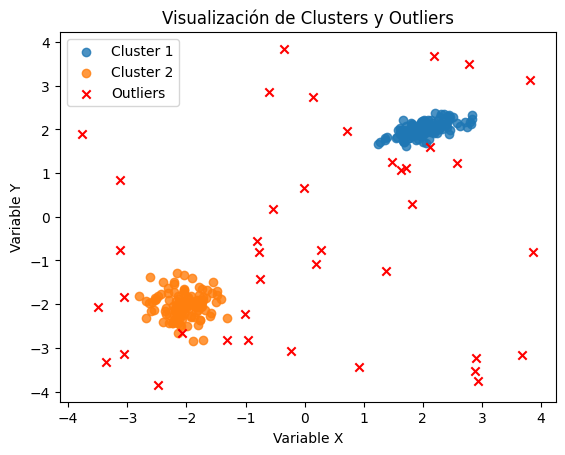

In [8]:
plt.scatter(cluster_1[:, 0], cluster_1[:, 1], label='Cluster 1', alpha=0.8)
plt.scatter(cluster_2[:, 0], cluster_2[:, 1], label='Cluster 2', alpha=0.8)
plt.scatter(outliers[:, 0], outliers[:, 1], label='Outliers', color='red', marker='x')

plt.title('Visualización de Clusters y Outliers')
plt.xlabel('Variable X')
plt.ylabel('Variable Y')
plt.legend()
plt.show()

Separamos los datos en datos de entrenamiento y datos de test.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

Ya tenemos los datos preparados, entrenamos el modelo IF detector de *outliers*.

In [14]:
clf = IsolationForest(max_samples=100, random_state=0)
clf.fit(X_train)

IsolationForest(max_samples=100, random_state=0)

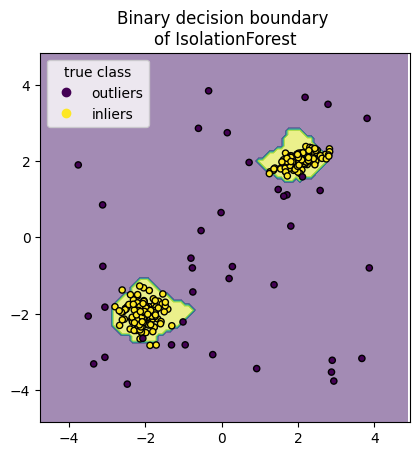

In [15]:
import matplotlib.pyplot as plt

from sklearn.inspection import DecisionBoundaryDisplay

disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    response_method="predict",
    alpha=0.5,
)
disp.ax_.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor="k")
disp.ax_.set_title("Binary decision boundary \nof IsolationForest")
plt.axis("square")
plt.legend(handles=handles, labels=["outliers", "inliers"], title="true class")
plt.show()

disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    response_method="decision_function",
    alpha=0.5,
)
disp.ax_.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor="k")
disp.ax_.set_title("Path length decision boundary \nof IsolationForest")
plt.axis("square")
plt.legend(handles=handles, labels=["outliers", "inliers"], title="true class")
plt.colorbar(disp.ax_.collections[1])
plt.show()

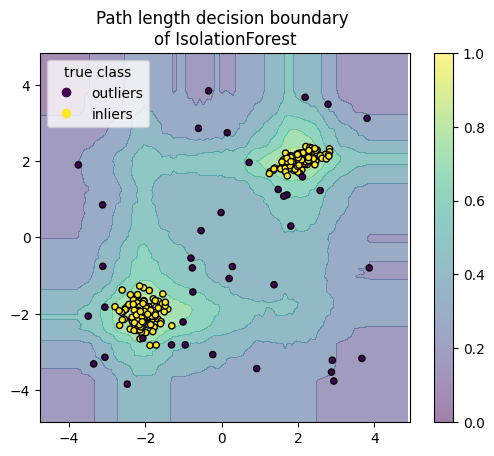

In [16]:
disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    response_method="decision_function",
    alpha=0.5,
)
disp.ax_.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor="k")
disp.ax_.set_title("Path length decision boundary \nof IsolationForest")
plt.axis("square")
plt.legend(handles=handles, labels=["outliers", "inliers"], title="true class")
plt.colorbar(disp.ax_.collections[1])
plt.show()

## Ejemplo 2 - NAB dataset

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

### Reconocimiento de los datos

Empezamos explorando los datos.

In [58]:
data_path = r"C:\Users\migue\OneDrive - Universitat de les Illes Balears\Proyectos\PhD\data\NAB datasets\realKnownCause\nyc_taxi.csv"

In [59]:
df = pd.read_csv(data_path)
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


Cómo siempre, nos aseguramos que los datos de fecha y hora estén bien formateados.

In [60]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

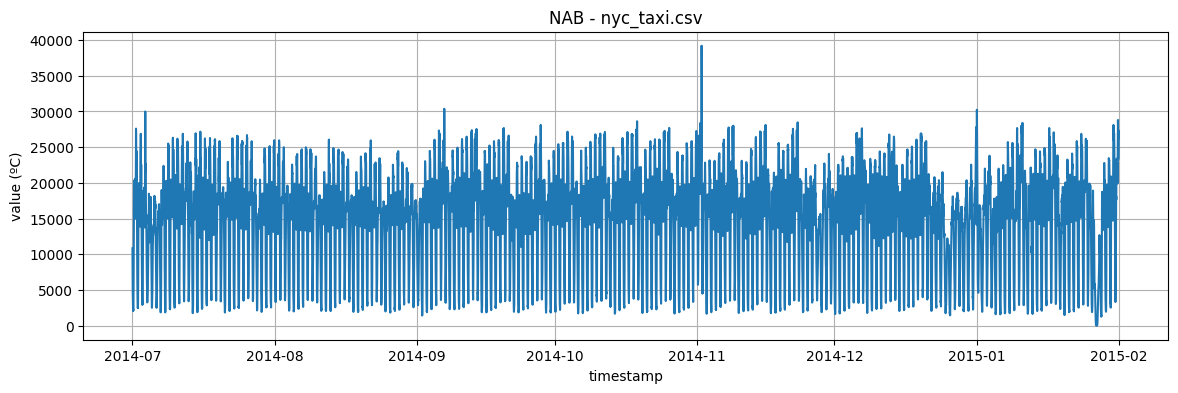

In [55]:
plt.figure(figsize=(14, 4))
plt.plot(df['timestamp'], df['value'])
plt.title('NAB - nyc_taxi.csv')
plt.xlabel('timestamp')
plt.ylabel('value (ºC)')
plt.grid(True)
plt.show()

Observar algo en este dataset tan grande es complicado. Haremos un "resampling" y en vez de trabajar de media hora en media hora, trabajaremos de hora en hora asumiendo que el valor medio de esta unión es representativa.

In [61]:
df=df.set_index('timestamp').resample("H").mean().reset_index()

df.head()

,timestamp,value
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5


In [62]:
df['hour']=df.timestamp.dt.hour
df['weekday']=pd.Categorical(df.timestamp.dt.strftime('%A'), categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'], ordered=True)

df.head()

,timestamp,value,hour,weekday
0,2014-07-01 00:00:00,9485.5,0,Tuesday
1,2014-07-01 01:00:00,5433.0,1,Tuesday
2,2014-07-01 02:00:00,3346.5,2,Tuesday
3,2014-07-01 03:00:00,2216.5,3,Tuesday
4,2014-07-01 04:00:00,2189.5,4,Tuesday


<Figure size 1000x600 with 0 Axes>

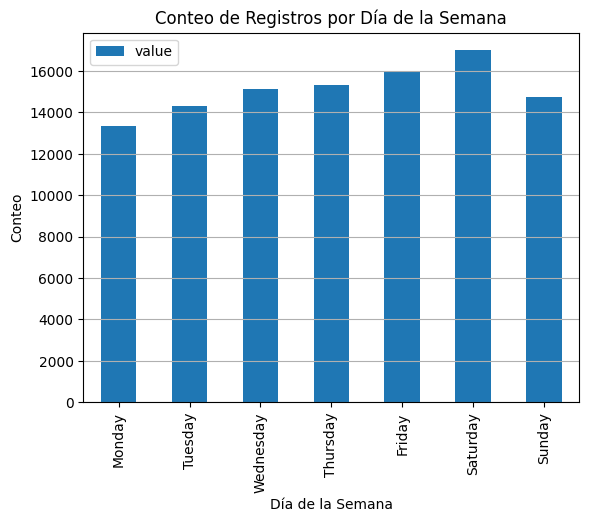

In [64]:
# Contar el número de registros por día de la semana
weekday_mean = df[['value', 'weekday']].groupby('weekday').mean()
weekday_mean = weekday_mean.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Graficar el conteo por día de la semana
plt.figure(figsize=(10, 6))
weekday_mean.plot(kind='bar')
plt.title('Conteo de Registros por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Conteo')
plt.grid(axis='y')
plt.show()

<Figure size 1200x400 with 0 Axes>

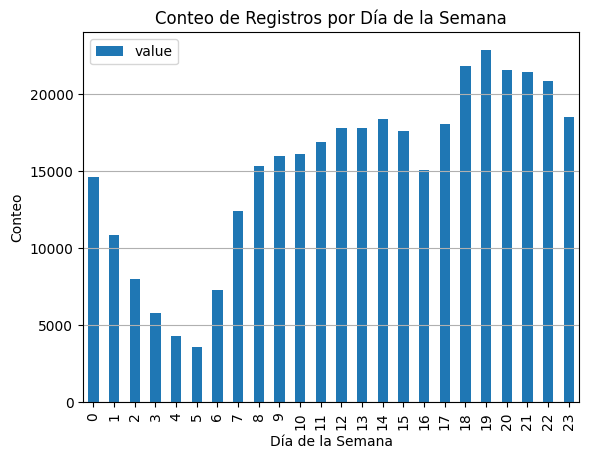

In [68]:
# Contar el número de registros por día de la semana
hours_mean = df[['value', 'hour']].groupby('hour').mean()

# Graficar el conteo por día de la semana
plt.figure(figsize=(12, 4))
hours_mean.plot(kind='bar')
plt.title('Conteo de Registros por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Conteo')
plt.grid(axis='y')
plt.show()

In [70]:
from sklearn.ensemble import IsolationForest

model =  IsolationForest(contamination=0.004)
model.fit(df[['value']])

IsolationForest(contamination=0.004)

In [72]:
df['outliers']=pd.Series(model.predict(df[['value']])).apply(lambda x: 'yes' if (x == -1) else 'no' )

df.head()

,timestamp,value,hour,weekday,outliers
0,2014-07-01 00:00:00,9485.5,0,Tuesday,no
1,2014-07-01 01:00:00,5433.0,1,Tuesday,no
2,2014-07-01 02:00:00,3346.5,2,Tuesday,no
3,2014-07-01 03:00:00,2216.5,3,Tuesday,no
4,2014-07-01 04:00:00,2189.5,4,Tuesday,no


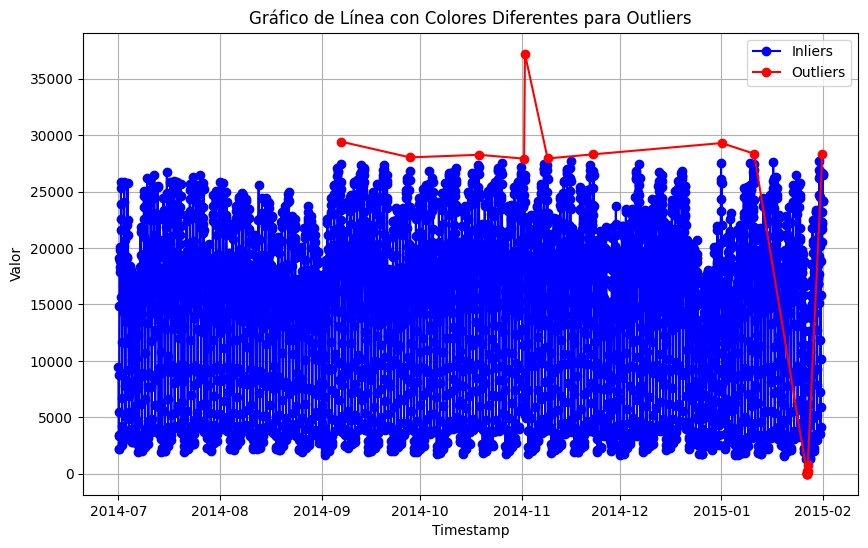

In [82]:
# Filtrar los datos para valores de 'outliers' igual a 'si' y 'no'
outliers_si = df[df['outliers'] == 'yes']
outliers_no = df[df['outliers'] == 'no']

# Crear el gráfico de línea
plt.figure(figsize=(10, 6))
plt.plot(outliers_no['timestamp'], outliers_no['value'], marker='o', color='blue', label='Inliers')
plt.plot(outliers_si['timestamp'], outliers_si['value'], marker='o', color='red', label='Outliers')
plt.title('Gráfico de Línea con Colores Diferentes para Outliers')
plt.xlabel('Timestamp')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

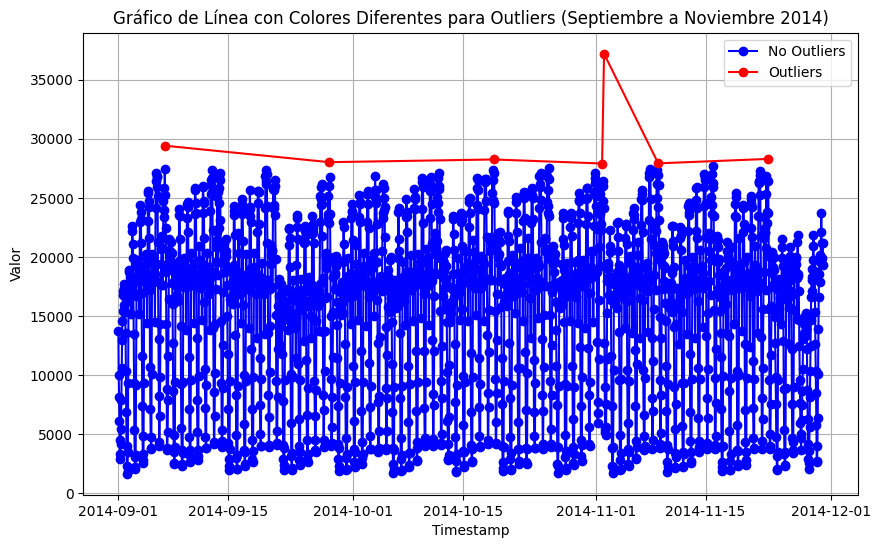

In [84]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
# Filtrar los datos para el rango de septiembre a noviembre del 2014
df_filtered = df[(df['timestamp'] >= '2014-09-01') & (df['timestamp'] <= '2014-11-30')]

# Filtrar los datos para valores de 'outliers' igual a 'si' y 'no'
outliers_si = df_filtered[df_filtered['outliers'] == 'yes']
outliers_no = df_filtered[df_filtered['outliers'] == 'no']

# Crear el gráfico de línea
plt.figure(figsize=(10, 6))
plt.plot(outliers_no['timestamp'], outliers_no['value'], marker='o', linestyle='-', color='blue', label='No Outliers')
plt.plot(outliers_si['timestamp'], outliers_si['value'], marker='o', linestyle='-', color='red', label='Outliers')
plt.title('Gráfico de Línea con Colores Diferentes para Outliers (Septiembre a Noviembre 2014)')
plt.xlabel('Timestamp')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()